### Bayesian Methods - Bayesian Regression

##### 1. Bayesian Polynomial Regression

The temperature of a town in Sweden over one year is hypothesised to be able of being modelled as a quadratic polynomial. The regression model is described as:
$$
t_i =\mathbf{w}^{\text{T}}\mathbf{\phi}(x) = w_0 + w_1 x + w_2 x^2 + \varepsilon_i,~~ \varepsilon_i \overset{\text{iid}}{\sim} N(0, \sigma^2) ~~ \forall i \in \{1,\ldots,|D|\}
$$
In which: 
$$
D \triangleq \{(x_i, t_i), i\in \{1,\ldots,n\}\}
$$

$$
t_i: \text{Temperature in $^\circ C$}
$$

$$
x_i: \text{Fraction of a year passed}
$$

$$
\mathbf{\phi}(x) = [1~~~x~~~x^2]^{\text{T}}
$$

Normally, we could simply fit the parameters $\mathbf{w}$ using OLS or MLE by solving the normal equations. With the Bayesian approach however, we have a prior distribution for the parameters $\mathbf{w}$ and $\sigma$. With this prior distribution we can find a posterior one using the likelihood function of $t_i$. After which, it is easy to find the optimal parameters by maximizing the posterior probability (MAP).

The prior distribution for this problem is the following:

$$
p(\mathbf{w}|\sigma^2) \sim N_3(0, \sigma^2 \mathbf{\Omega}_0)
$$

$$
p(\sigma^2) \sim \text{Scale-Inv-}\chi^2(\nu_0, \sigma^2_0)
$$

Notice: the joint prior is split $p(\mathbf{w}, \sigma^2) = p(\mathbf{w}|\sigma^2)p(\sigma^2)$. 

This prior will correspond to Tikhonov (L2/Ridge) regularization.

In [7]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['science', 'notebook', 'grid'])

In [86]:
df = pd.read_csv('data/TempLambohov.txt', delimiter='   ', engine='python')
df.insert(0, 'constant', np.ones(len(df)))
df.insert(2, 'time squared', df['time']**2)

# Design matrix and target vector.
X = np.array(df[df.columns[0:3]])
y = np.array(df['temp'])

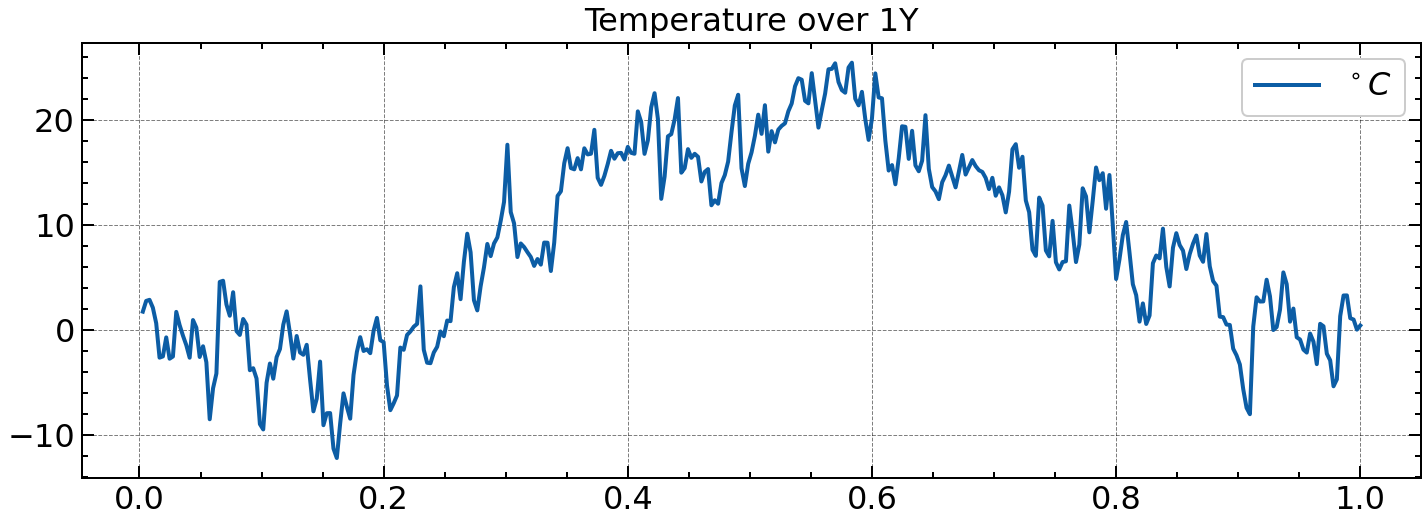

In [106]:
fig, ax = plt.subplots()
ax.plot(df['time'], df['temp'], label='$^\circ C$')
ax.set_title('Temperature over 1Y')
ax.legend()

fig.set_size_inches(12, 4)
plt.show()

##### Prior Distribution Hyperparameter Fit

We can ascertain sensible hyperparameters in the prior distribution by ad-hoc simulating the prior-implied models and tweaking the parameters. This was done below until a satisfactory result was obtained.

In [105]:
# Prior Hyperparameters
mu_0 = np.array([-10, 100, -100])
omega_0 = 0.02 * np.identity(3)
nu_0 = 3
sigma_0 = 2

In [120]:
from scipy.stats import multivariate_normal, chi2

def simulate_s(nu: float, sigma: float) -> np.array:
    chi2_variables = chi2.rvs(nu)
    return np.array(sigma * nu * (1 / chi2_variables))

def simulate_w(mu: np.array, omega: np.array, sigma: float) -> np.array:
    return np.array(multivariate_normal.rvs(mu, sigma * omega))

In [137]:
def simulate_curves(mu: np.array, omega: np.array, sigma: float, nu: float, size: int) -> list:
    set_of_curves = []
    for _ in range(size):
        sigma_sim = simulate_s(nu, sigma)
        weights_sim = simulate_w(mu, omega, sigma_sim)
        epsilon = multivariate_normal.rvs(np.zeros(len(df)), sigma_sim * np.identity(len(df)))
        y_sim = X @ weights_sim + epsilon
        set_of_curves.append(y_sim)
        
    return set_of_curves

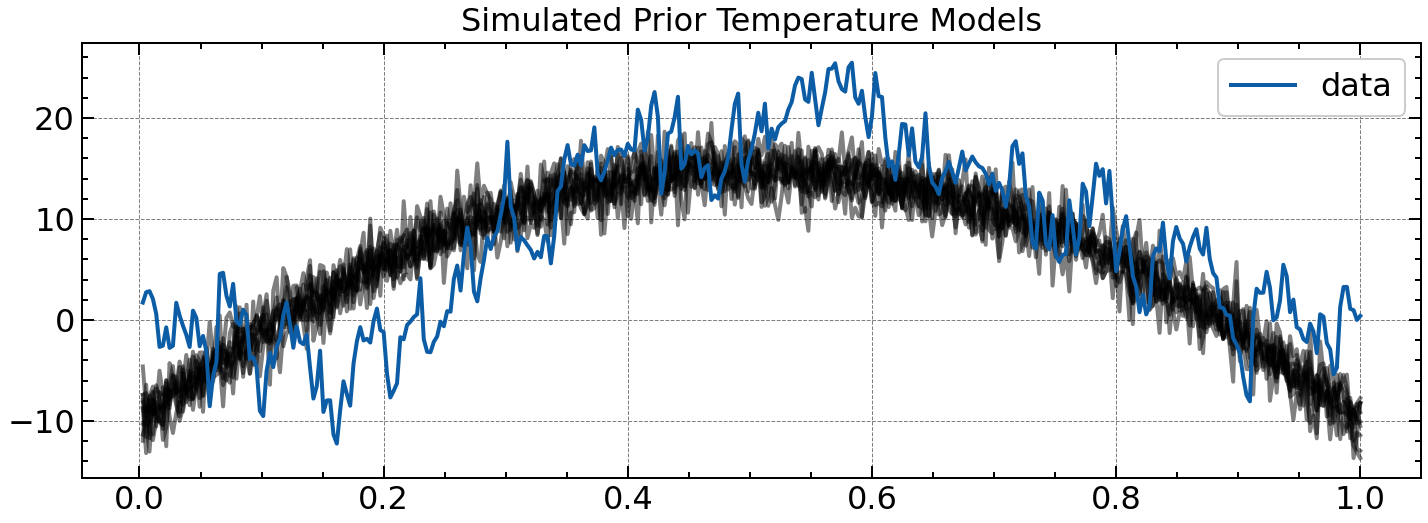

In [138]:
# Simulating prior implied curves.
prior_curves = simulate_curves(mu_0, omega_0, sigma_0, nu_0, 10)

fig, ax = plt.subplots()
for curve in prior_curves:
    ax.plot(df['time'], curve, color='black', alpha=0.5)
ax.plot(df['time'], y, label='data')
ax.legend()
ax.set_title('Simulated Prior Temperature Models')

fig.set_size_inches(12, 4)
plt.show()

##### Posterior Distribution and Model Fit

The likelihood function of $\mathbf{t}$ can be written as a multivariate normal density. That is $\mathbf{t} \sim N(\mathbf{X}\mathbf{w}, \sigma^2)$ gives us the likelihood function $p(D|\mathbf{\theta})$. Used in conjunction with the prior we can derive that the posterior distribution follows the distributions given below (again decomposed into $\mathbf{w}$ and $\sigma^2$).

$$
\mathbf{\mu}_n = (\mathbf{X}^T\mathbf{X}+\mathbf{\Omega}_0)^{-1}(\mathbf{X}^T\mathbf{X}\mathbf{\hat{w}}+\mathbf{\Omega}_0\mathbf{\mu}_0)
$$
$$
\mathbf{\Omega}_n = \mathbf{X}^T\mathbf{X} + \mathbf{\Omega}_0
$$
$$
\nu_n = \nu_0 + n
$$
$$
\nu_n \sigma^2_n = \nu_0 \sigma^2_0 +(\mathbf{t}^T\mathbf{t} + \mathbf{\mu}^T_0\mathbf{\Omega}_0\mathbf{\mu}_0 - \mathbf{\mu}^T_n\mathbf{\Omega}_n\mathbf{\mu}_n)
$$

In which $\mathbf{\hat{w}} = \mathbf{X}^{\dagger}\mathbf{t}= (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{t}$, is the OLS solution.

In [117]:
# Solving OLS parameters.
beta_ols = np.linalg.inv(X.T @ X) @ X.T @ y

# Updated posterior parameters.
mu_n = np.linalg.inv(X.T @ X + omega_0) @ (X.T @ X @ beta_ols + omega_0 @ mu_0)
omega_n = X.T @ X + omega_0
nu_n = nu_0 + len(df)
sigma_n = (nu_0 * sigma_0 + y.T @ y + mu_0.T @ omega_0 @ mu_0.T - mu_n.T @ omega_n @ mu_n) / nu_n

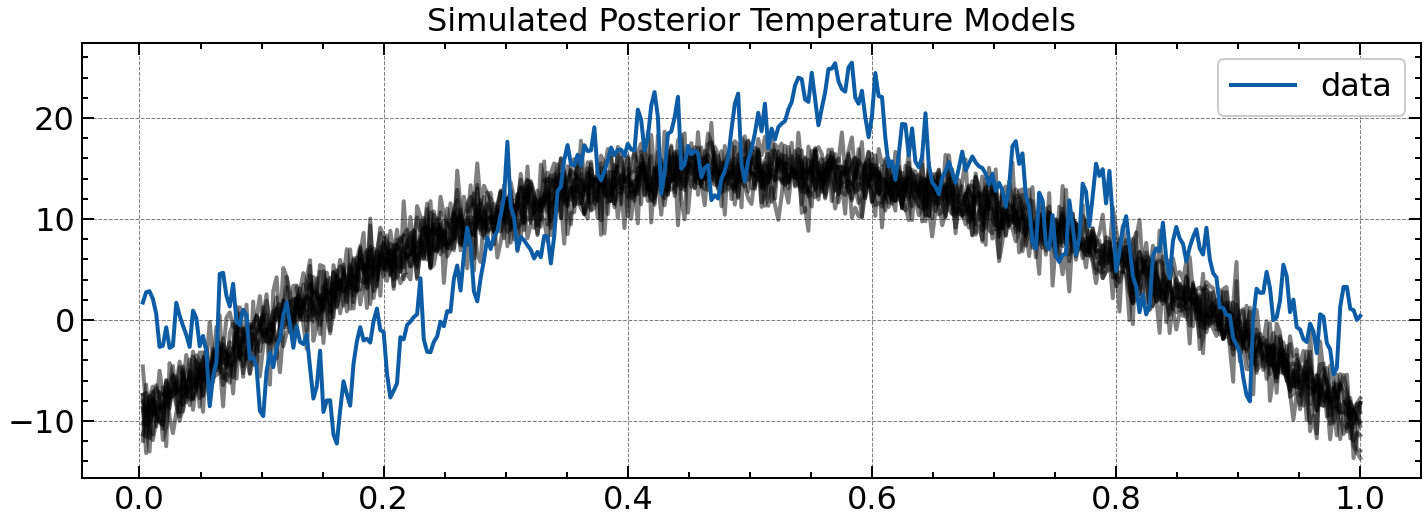

In [140]:
# Simulating posterior implied curves.
posterior_curves = simulate_curves(mu_n, omega_n, sigma_n, nu_n, 10)

fig, ax = plt.subplots()
for curve in prior_curves:
    ax.plot(df['time'], curve, color='black', alpha=0.5)
ax.plot(df['time'], y, label='data')
ax.legend()
ax.set_title('Simulated Posterior Temperature Models')

fig.set_size_inches(12, 4)
plt.show()

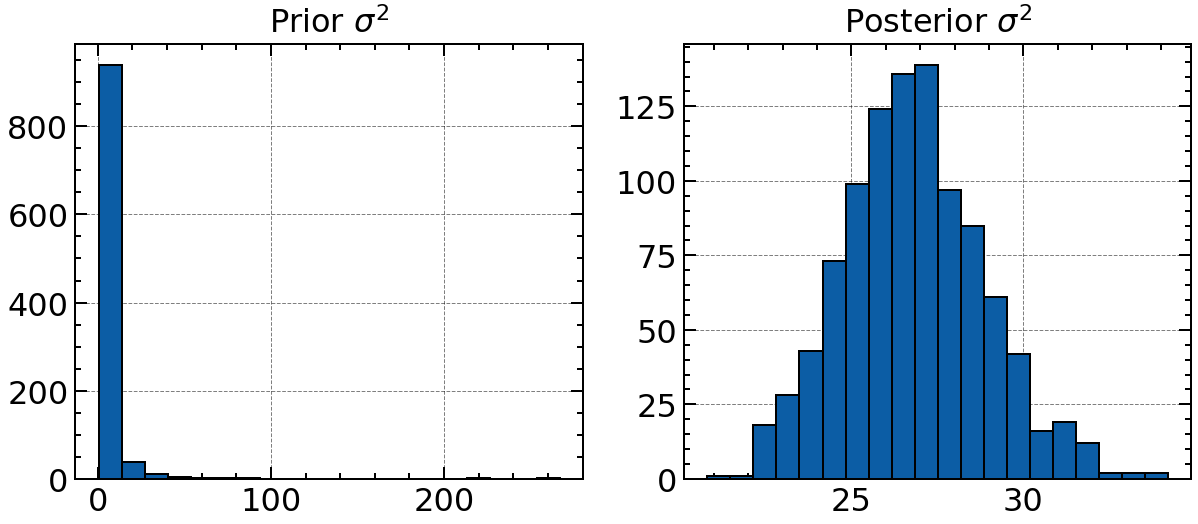

In [214]:
# Simlated sigma parameter distributions.
fig, axs = plt.subplots(1, 2)
axs[0].set_title('Prior $\sigma^2$')
axs[0].hist([float(simulate_s(nu_0, sigma_0)) for _ in range(1000)], bins=20, edgecolor='black')
axs[1].set_title('Posterior $\sigma^2$')
axs[1].hist([float(simulate_s(nu_n, sigma_n)) for _ in range(1000)], bins=20, edgecolor='black')
fig.set_size_inches(10, 4)
plt.show()

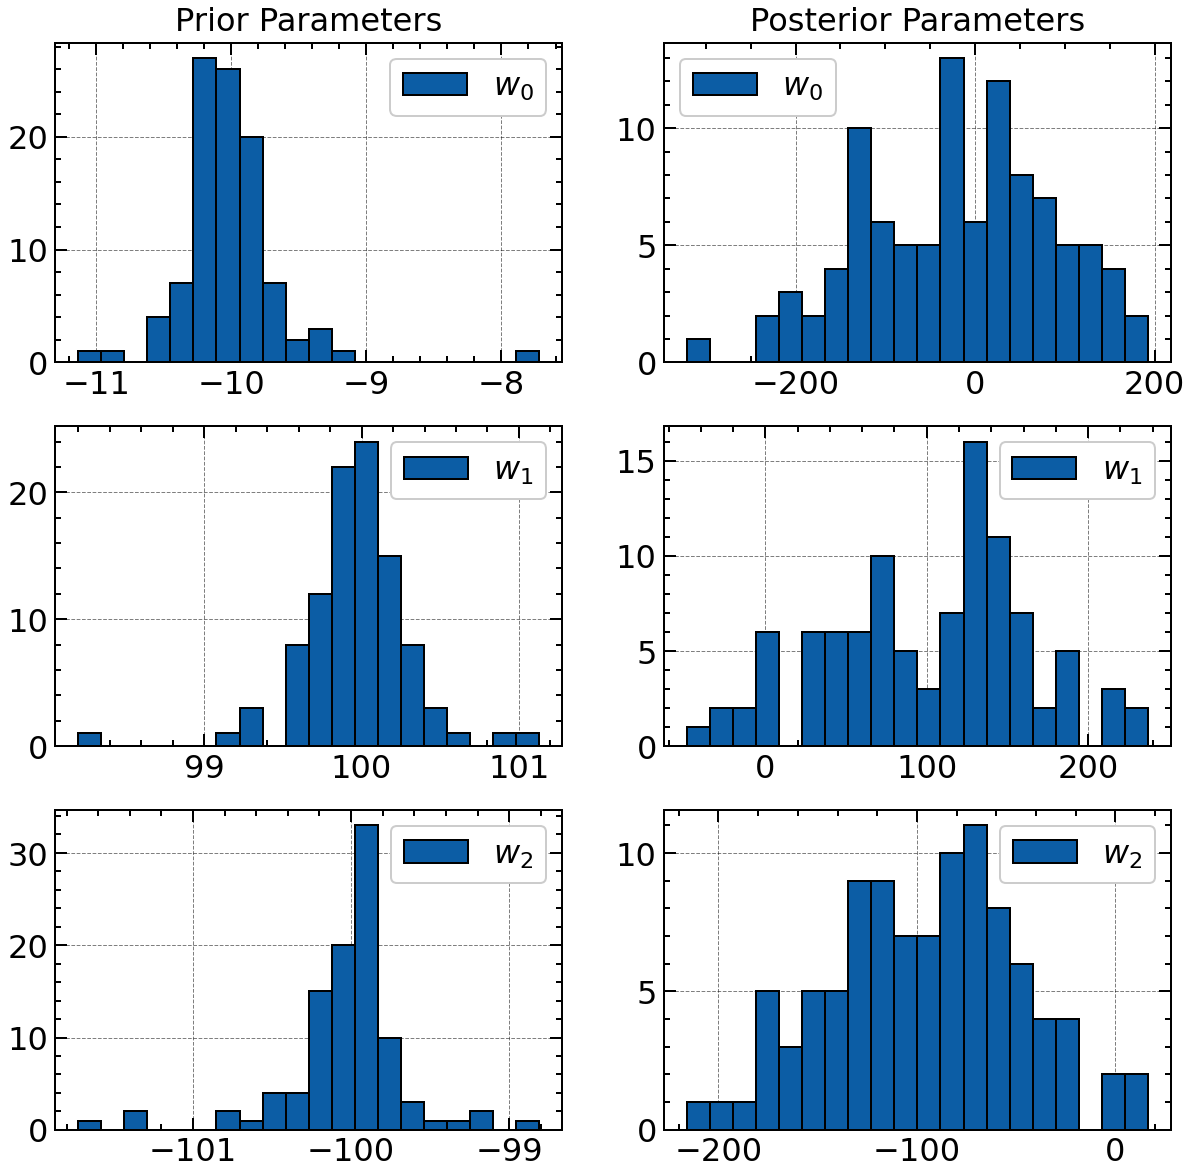

In [218]:
# Simlated prior and posterior parameter distributions.
fig, axs = plt.subplots(3, 2)
prior_w = []
posterior_w = []
for _ in range(100):
    
    s_prior = simulate_s(nu_0, sigma_0)
    prior_w.append(simulate_w(mu_0, omega_0, s_prior))

    s_posterior = simulate_s(nu_n, sigma_n)
    posterior_w.append(simulate_w(mu_n, omega_n, s_posterior))

axs[0, 0].hist([float(w[0]) for w in prior_w], label='$w_0$', bins=20, edgecolor='black')
axs[0, 1].hist([float(w[0]) for w in posterior_w], label='$w_0$', bins=20, edgecolor='black')
axs[0, 0].set_title('Prior Parameters')
axs[0, 1].set_title('Posterior Parameters')
axs[0, 0].legend()
axs[0, 1].legend()

axs[1, 0].hist([float(w[1]) for w in prior_w], label='$w_1$', bins=20, edgecolor='black')
axs[1, 1].hist([float(w[1]) for w in posterior_w], label='$w_1$', bins=20, edgecolor='black')
axs[1, 0].legend()
axs[1, 1].legend()

axs[2, 0].hist([float(w[2]) for w in prior_w], label='$w_2$', bins=20, edgecolor='black')
axs[2, 1].hist([float(w[2]) for w in posterior_w], label='$w_2$', bins=20, edgecolor='black')
axs[2, 0].legend()
axs[2, 1].legend()

fig.set_size_inches(10, 10)
plt.show()

In [220]:
# Simulated mean solution with credible interval.


In [144]:
# Distribution of optimal time (max. temperature).


In [221]:
# Lasso regularization. 
